In [ ]:
Objective

In [ ]:
# Used to install a package not included by default
!pip install category_encoders
!pip install eli5
!pip install shap


In [1]:
# Importing packages
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Importing Hashing Encoder
from category_encoders import HashingEncoder

# Importing a more complex imputer for missing values
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Importing machine learning models
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Importing evaluating and model selection tools
from sklearn.model_selection import cross_val_score, train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, max_error
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.feature_selection import SelectFromModel
import shap

# Packages for visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# Importing data
sb_full_menu = pd.read_csv('starbucks_drinkMenu_expanded.csv')
sb_drink_menu = pd.read_csv('starbucks-menu-nutrition-drinks.csv')
sb_food_menu = pd.read_csv('starbucks-menu-nutrition-food.csv', encoding='utf-16')
print('Done!')

# We also want to set the index of dataset 2 and 3 to the drink name, as this will simplify future analysis
sb_drink_menu.set_index('Unnamed: 0', inplace=True)
sb_food_menu.set_index('Unnamed: 0', inplace=True)

# Rename columns
sb_full_menu = sb_full_menu.rename(columns={' Total Fat (g)': 'Total Fat', 'Trans Fat (g) ': 'Trans Fat',
                                            'Saturated Fat (g)': 'Saturated Fat', ' Sodium (mg)': 'Sodium',
                                            ' Total Carbohydrates (g) ': 'Total Carbohydrates',
                                            'Cholesterol (mg)': 'Cholesterol', ' Dietary Fibre (g)': 'Dietary Fibre',
                                            ' Sugars (g)': 'Sugars', ' Protein (g) ': 'Protein',
                                            'Vitamin A (% DV) ': 'Vitamin A (% DV)', ' Calcium (% DV) ': 'Calcium (% DV)',
                                            'Iron (% DV) ': 'Iron (% DV)', 'Caffeine (mg)': 'Caffeine'})
sb_food_menu = sb_food_menu.rename(columns={' Calories': 'Calories', ' Fat (g)':'Fat', ' Carb. (g)': 'Carbohydrates', ' Fiber (g)': 'Fiber',
                                            ' Protein (g)': 'Protein'})
sb_drink_menu = sb_drink_menu.rename(columns={'Fat (g)':'Fat', 'Carb. (g)': 'Carbohydrates', 'Fiber (g)': 'Fiber'})

# Cleaning drink_menu
sb_drink_menu.replace('-', '', regex=True, inplace=True)
columns_to_change = ['Calories', 'Fat', 'Carbohydrates', 'Fiber', 'Protein', 'Sodium']
sb_drink_menu[columns_to_change] = sb_drink_menu[columns_to_change].apply(pd.to_numeric)

sb_drink_menu.dropna(inplace=True) # Drop NA rows
sb_drink_menu = sb_drink_menu[~sb_drink_menu.index.duplicated()] # Drop rows with duplicate indices

Done!


In [2]:
# X is what we are using for prediction, and y is what is being predicted
# We are trying to predict calories, so that'll be our y
X = sb_full_menu.loc[:, sb_full_menu.columns!='Calories'] # All columns except Calories
y = sb_full_menu.loc[:, 'Calories']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=24) 
# We'll have a test size of 25% of the data

In [3]:
# Data Cleaning

# Replace troublesome entry
X_train.loc[237, 'Total Fat'] = '3.2'

def data_cleaning(df):
    data = df.copy()
    # Add "0." in front
    data['Vitamin A (% DV)'] = "0." + data['Vitamin A (% DV)']
    data['Vitamin C (% DV)'] = "0." + data['Vitamin C (% DV)']
    data['Calcium (% DV)'] = "0." + data['Calcium (% DV)']
    data['Iron (% DV)'] = "0." + data['Iron (% DV)']
    # Remove "%" from percent columns
    data = data.replace({'Vitamin A (% DV)': {'%': ''}, 'Vitamin C (% DV)': {'%': ''},
                                     'Calcium (% DV)': {'%': ''}, 'Iron (% DV)': {'%': ''}}, regex=True)

    # 'Iron (% DV)' includes percentages in the form of #.00%, so we will need to do some more work
    data = data.replace({'Iron (% DV)': {'.00': ''}}, regex=True)
    # Impute None for "Varies" because we don't know value
    data = data.replace({'Caffeine': {'Varies': None, 'varies': None}})
    # Now we will convert the columns to a number format using the .to_numeric function
    # We use the .apply function to apply .to_numeric to multiple columns
    columns_to_change = ['Total Fat', 'Caffeine', 'Vitamin A (% DV)', 'Vitamin C (% DV)', 'Calcium (% DV)',
                         'Iron (% DV)']
    data[columns_to_change] = data[columns_to_change].apply(pd.to_numeric)

    # Iterative Imputation
    iter_imputer = IterativeImputer(missing_values=np.nan, max_iter=10, verbose=0, imputation_order='roman', 
                                    random_state=24)
    data_num = data.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64'])
    imp_num = pd.DataFrame(iter_imputer.fit_transform(data_num), columns=data_num.columns, index=data.index)
    data.iloc[:,3:] = imp_num
    print("Done!")
    return(data)
  
X_train_clean = data_cleaning(X_train)
X_test_clean = data_cleaning(X_test)

Done!
Done!


In [4]:
categorical_columns_1 = ['Beverage_category', 'Beverage', 'Beverage_prep'] 
# Categorical columns for sb_full_menu
categorical_columns_1 = X_train_clean.select_dtypes(include='object').columns 
# Another way to find categorical columns

print(sb_full_menu[categorical_columns_1].nunique())

Beverage_category     9
Beverage             33
Beverage_prep        13
dtype: int64


In [5]:
X_train_pro = pd.get_dummies(X_train_clean, columns=['Beverage_category'])
X_test_pro = pd.get_dummies(X_test_clean, columns=['Beverage_category'])

In [6]:
# A look at what is actually occuring to the data from one-hot encoding
sb_full_menu = pd.get_dummies(sb_full_menu, columns=['Beverage_category'])
sb_full_menu.head()

,Beverage,Beverage_prep,Calories,Total Fat,Trans Fat,Saturated Fat,Sodium,Total Carbohydrates,Cholesterol,Dietary Fibre,...,Caffeine,Beverage_category_Classic Espresso Drinks,Beverage_category_Coffee,Beverage_category_Frappuccino® Blended Coffee,Beverage_category_Frappuccino® Blended Crème,Beverage_category_Frappuccino® Light Blended Coffee,Beverage_category_Shaken Iced Beverages,Beverage_category_Signature Espresso Drinks,Beverage_category_Smoothies,Beverage_category_Tazo® Tea Drinks
0,Brewed Coffee,Short,3,0.1,0.0,0.0,0,5,0,0,...,175,0,1,0,0,0,0,0,0,0
1,Brewed Coffee,Tall,4,0.1,0.0,0.0,0,10,0,0,...,260,0,1,0,0,0,0,0,0,0
2,Brewed Coffee,Grande,5,0.1,0.0,0.0,0,10,0,0,...,330,0,1,0,0,0,0,0,0,0
3,Brewed Coffee,Venti,5,0.1,0.0,0.0,0,10,0,0,...,410,0,1,0,0,0,0,0,0,0
4,Caffè Latte,Short Nonfat Milk,70,0.1,0.1,0.0,5,75,10,0,...,75,1,0,0,0,0,0,0,0,0


In [7]:
# n_components determines how many columns you'll have afterward, here we'll transform 2 columns into 8 columns
hash_encoder = HashingEncoder(cols=['Beverage', 'Beverage_prep'], n_components=8)
X_train_pro = hash_encoder.fit_transform(X_train_pro)
X_test_pro = hash_encoder.fit_transform(X_test_pro)
X_pro_colnames = X_test_pro.columns.tolist() # We'll use this line later to keep column names
X_train_pro.head()

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,Total Fat,Trans Fat,...,Caffeine,Beverage_category_Classic Espresso Drinks,Beverage_category_Coffee,Beverage_category_Frappuccino® Blended Coffee,Beverage_category_Frappuccino® Blended Crème,Beverage_category_Frappuccino® Light Blended Coffee,Beverage_category_Shaken Iced Beverages,Beverage_category_Signature Espresso Drinks,Beverage_category_Smoothies,Beverage_category_Tazo® Tea Drinks
91,0,1,0,0,1,0,0,0,6.0,1.5,...,20.0,0,0,0,0,0,0,1,0,0
54,0,2,0,0,0,0,0,0,6.0,3.0,...,150.0,1,0,0,0,0,0,0,0,0
186,0,1,1,0,0,0,0,0,1.5,0.2,...,95.0,0,0,1,0,0,0,0,0,0
68,0,1,0,0,1,0,0,0,1.0,1.0,...,150.0,0,0,0,0,0,0,1,0,0
197,1,0,0,0,0,1,0,0,6.0,3.5,...,140.0,0,0,1,0,0,0,0,0,0


# Standardizing Data


In [ ]:
We would like our data to be on the same scale, and some machine learning models work better
with standardized data. There are multiple scalars available from scikit-learn, but the Standard 
Scalar we used in the workshop works well enough.

In [8]:
scaler = StandardScaler()
X_train_pro = pd.DataFrame(scaler.fit_transform(X_train_pro), columns=X_pro_colnames)
X_test_pro = pd.DataFrame(scaler.fit_transform(X_test_pro), columns=X_pro_colnames)
X_train_pro.head()

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,Total Fat,Trans Fat,...,Caffeine,Beverage_category_Classic Espresso Drinks,Beverage_category_Coffee,Beverage_category_Frappuccino® Blended Coffee,Beverage_category_Frappuccino® Blended Crème,Beverage_category_Frappuccino® Light Blended Coffee,Beverage_category_Shaken Iced Beverages,Beverage_category_Signature Espresso Drinks,Beverage_category_Smoothies,Beverage_category_Tazo® Tea Drinks
0,-0.289538,0.432037,-0.342467,-0.427793,1.195965,-0.759165,-0.241825,-0.266469,1.082626,0.138051,...,-1.084873,-0.592238,-0.129823,-0.427793,-0.228748,-0.185164,-0.241825,2.117746,-0.215041,-0.506897
1,-0.289538,2.209283,-0.342467,-0.427793,-0.702892,-0.759165,-0.241825,-0.266469,1.082626,1.116663,...,0.979085,1.688509,-0.129823,-0.427793,-0.228748,-0.185164,-0.241825,-0.472200,-0.215041,-0.506897
2,-0.289538,0.432037,2.919986,-0.427793,-0.702892,-0.759165,-0.241825,-0.266469,-0.515125,-0.710080,...,0.105872,-0.592238,-0.129823,2.337581,-0.228748,-0.185164,-0.241825,-0.472200,-0.215041,-0.506897
3,-0.289538,0.432037,-0.342467,-0.427793,1.195965,-0.759165,-0.241825,-0.266469,-0.692653,-0.188153,...,0.979085,-0.592238,-0.129823,-0.427793,-0.228748,-0.185164,-0.241825,2.117746,-0.215041,-0.506897
4,3.453776,-1.345208,-0.342467,-0.427793,-0.702892,1.072954,-0.241825,-0.266469,1.082626,1.442867,...,0.820319,-0.592238,-0.129823,2.337581,-0.228748,-0.185164,-0.241825,-0.472200,-0.215041,-0.506897


In [11]:
# Function to print out evaluation metrics
def eval_model(y_test, predictions):
    print("RMSE: ", np.sqrt(mean_squared_error(y_test, predictions)))
    print("MAE: ", mean_absolute_error(y_test, predictions))
    print("Max Error: ", max_error(y_test, predictions))
    print("Percentage Error:", round(mean_absolute_error(y_test, predictions) / sb_full_menu['Calories'].mean(), 5))
    return None

In [10]:
# Fitting linear regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train_pro, y_train)
lin_reg_pred = lin_reg.predict(X_test_pro)
print("R2 (Specific to Linear Regression): ", lin_reg.score(X_train_pro, y_train))
eval_model(y_test, lin_reg_pred)


R2 (Specific to Linear Regression):  0.9979815105806952
RMSE:  64744295551226.21
MAE:  55364070769458.58
Max Error:  128982476644254.44
Percentage Error: 285570371639.4692


In [12]:
# Fitting random forest model
rf_model = RandomForestRegressor(n_estimators=100, n_jobs=4)
rf_model.fit(X_train_pro, y_train)
rf_pred = rf_model.predict(X_test_pro)
eval_model(y_test, rf_pred)

RMSE:  26.310398960156856
MAE:  20.680163934426233
Max Error:  80.60000000000002
Percentage Error: 0.10667


In [13]:
# Fitting XGBoost model
xgb_model = XGBRegressor(n_estimators=35, n_jobs=4)
xgb_model.fit(X_train_pro, y_train)
xgb_pred = xgb_model.predict(X_test_pro)
eval_model(y_test, xgb_pred)

RMSE:  27.3644614732457
MAE:  22.306156908879515
Max Error:  88.1993408203125
Percentage Error: 0.11506


# Model Evaluation

In [14]:
lin_perm = PermutationImportance(lin_reg, random_state=1).fit(X_test_pro, y_test)
eli5.show_weights(lin_perm, feature_names = X_pro_colnames)

Weight,Feature
15952026605340557699973120.0000 ± 4498276720501324733480960.0000,col_1
12529286207746897717755904.0000 ± 2563247778388138331734016.0000,col_5
11748452075663904347258880.0000 ± 2117717598962806377414656.0000,col_4
4314678512867374213890048.0000 ± 960832596596925239656448.0000,col_3
3784485980536261742428160.0000 ± 1193336536655257751519232.0000,col_2
3393234492812136615510016.0000 ± 764144802688106581983232.0000,col_0
2168079025186210551169024.0000 ± 210418469412717396492288.0000,col_6
1999639252564988831727616.0000 ± 1047852995954699143217152.0000,col_7
9140227276.8000 ± 5960476169.2720,Caffeine
8428873318.4000 ± 17567372803.0483,Trans Fat


In [15]:
# This one can take a bit to run
rf_perm = PermutationImportance(rf_model, random_state=1).fit(X_test_pro, y_test)
eli5.show_weights(rf_perm, feature_names = X_pro_colnames)

Weight,Feature
1.3635 ± 0.2937,Cholesterol
0.0461 ± 0.0111,Total Fat
0.0163 ± 0.0052,Protein
0.0108 ± 0.0023,Trans Fat
0.0105 ± 0.0044,Total Carbohydrates
0.0069 ± 0.0053,Sugars
0.0041 ± 0.0017,Calcium (% DV)
0.0036 ± 0.0032,Vitamin C (% DV)
0.0024 ± 0.0009,Sodium
0.0022 ± 0.0012,Vitamin A (% DV)


In [16]:
xgb_perm = PermutationImportance(xgb_model, random_state=1).fit(X_test_pro, y_test)
eli5.show_weights(xgb_perm, feature_names = X_pro_colnames)

Weight,Feature
1.3867 ± 0.3159,Cholesterol
0.0591 ± 0.0106,Total Fat
0.0227 ± 0.0094,Total Carbohydrates
0.0221 ± 0.0052,Protein
0.0028 ± 0.0042,col_2
0.0020 ± 0.0017,Iron (% DV)
0.0014 ± 0.0043,Caffeine
0.0013 ± 0.0012,col_4
0.0011 ± 0.0005,Beverage_category_Frappuccino® Light Blended Coffee
0.0011 ± 0.0026,Sodium


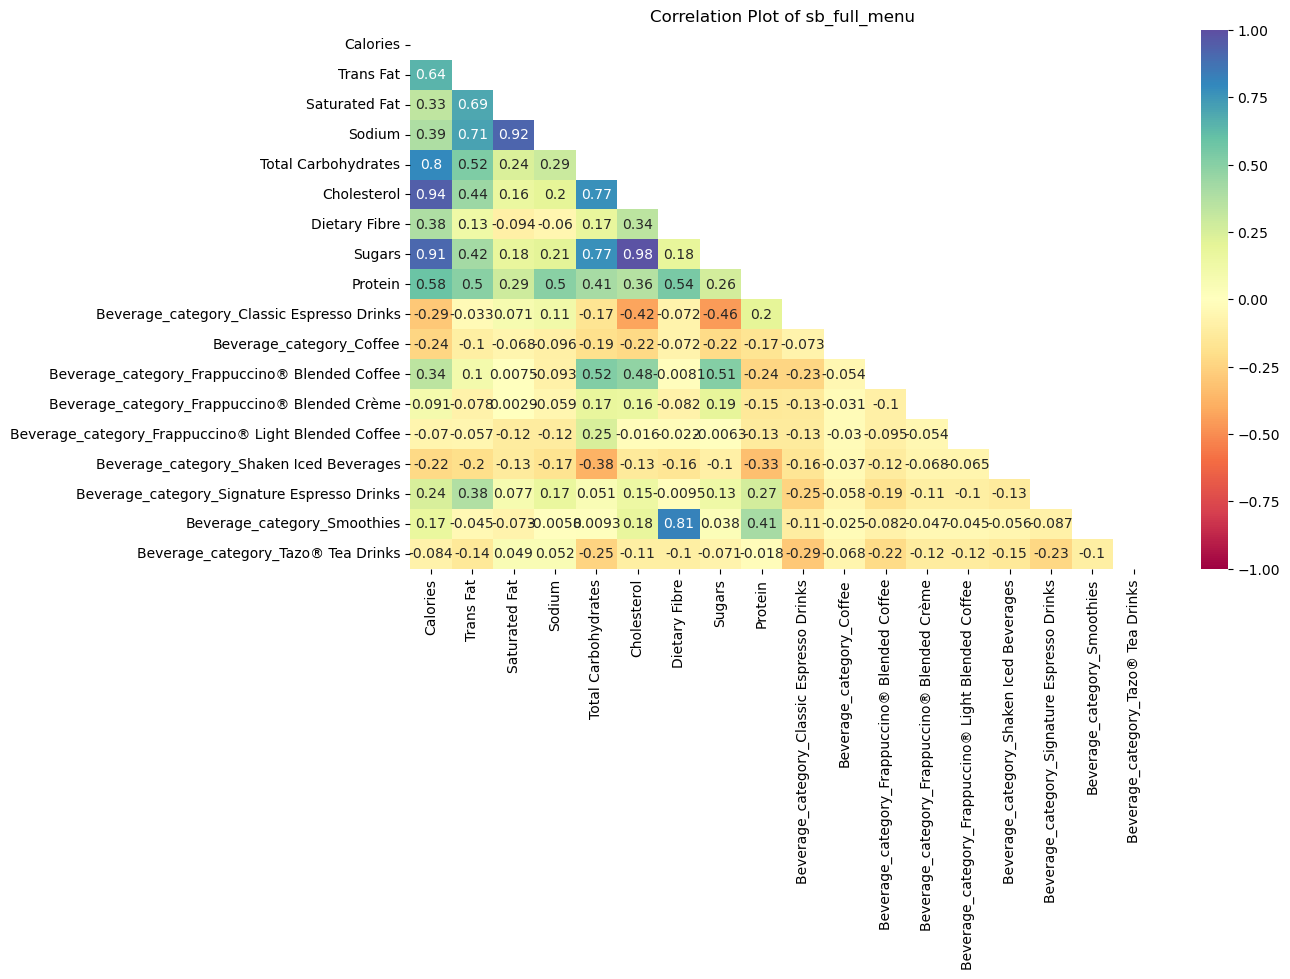

In [17]:
plt.figure(figsize=(12, 7))
mask = np.triu(np.ones_like(sb_full_menu.corr(), dtype=bool)) # Used to make a triangular plot
corrplot = sns.heatmap(sb_full_menu.corr(), vmin=-1, vmax=1, annot=True, mask=mask, 
                       cmap='Spectral').set_title("Correlation Plot of sb_full_menu")
plt.show()

In [18]:
# Dropping unimportant columns from X_train and X_test
select = SelectFromModel(lin_perm, threshold=0.008, prefit=True)
X_train_select = pd.DataFrame(select.transform(X_train_pro))
X_test_select = pd.DataFrame(select.transform(X_test_pro))

# Adding back names to columns
sel_cols = [X_train_pro.columns[i] for i in range(len(X_train_pro.columns)) if select.get_support()[i]]
sel_name = {}
for idx in range(len(sel_cols)):
    sel_name[idx] = sel_cols[idx]
X_train_select = X_train_select.rename(columns=sel_name)
X_test_select = X_test_select.rename(columns=sel_name)
X_train_select.head()

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,Total Fat,Trans Fat,...,Caffeine,Beverage_category_Classic Espresso Drinks,Beverage_category_Coffee,Beverage_category_Frappuccino® Blended Coffee,Beverage_category_Frappuccino® Blended Crème,Beverage_category_Frappuccino® Light Blended Coffee,Beverage_category_Shaken Iced Beverages,Beverage_category_Signature Espresso Drinks,Beverage_category_Smoothies,Beverage_category_Tazo® Tea Drinks
0,-0.289538,0.432037,-0.342467,-0.427793,1.195965,-0.759165,-0.241825,-0.266469,1.082626,0.138051,...,-1.084873,-0.592238,-0.129823,-0.427793,-0.228748,-0.185164,-0.241825,2.117746,-0.215041,-0.506897
1,-0.289538,2.209283,-0.342467,-0.427793,-0.702892,-0.759165,-0.241825,-0.266469,1.082626,1.116663,...,0.979085,1.688509,-0.129823,-0.427793,-0.228748,-0.185164,-0.241825,-0.472200,-0.215041,-0.506897
2,-0.289538,0.432037,2.919986,-0.427793,-0.702892,-0.759165,-0.241825,-0.266469,-0.515125,-0.710080,...,0.105872,-0.592238,-0.129823,2.337581,-0.228748,-0.185164,-0.241825,-0.472200,-0.215041,-0.506897
3,-0.289538,0.432037,-0.342467,-0.427793,1.195965,-0.759165,-0.241825,-0.266469,-0.692653,-0.188153,...,0.979085,-0.592238,-0.129823,-0.427793,-0.228748,-0.185164,-0.241825,2.117746,-0.215041,-0.506897
4,3.453776,-1.345208,-0.342467,-0.427793,-0.702892,1.072954,-0.241825,-0.266469,1.082626,1.442867,...,0.820319,-0.592238,-0.129823,2.337581,-0.228748,-0.185164,-0.241825,-0.472200,-0.215041,-0.506897


In [19]:
# Random Forest Model
select = SelectFromModel(rf_perm, threshold=0.002, prefit=True)
X_train_select = pd.DataFrame(select.transform(X_train_pro))
X_test_select = pd.DataFrame(select.transform(X_test_pro))
X_train_select.head()

rf_model = RandomForestRegressor(n_estimators=100, n_jobs=4)
rf_model.fit(X_train_select, y_train)
rf_pred = rf_model.predict(X_test_select)
eval_model(y_test, rf_pred)


RMSE:  25.16148781078852
MAE:  20.523934426229513
Max Error:  65.30000000000001
Percentage Error: 0.10586


In [20]:
# XGBoost Model
select = SelectFromModel(xgb_perm, threshold=0.001, prefit=True)
X_train_select = pd.DataFrame(select.transform(X_train_pro))
X_test_select = pd.DataFrame(select.transform(X_test_pro))
X_train_select.head()

xgb_model = XGBRegressor(n_estimators=35, n_jobs=4)
xgb_model.fit(X_train_select, y_train)
xgb_pred = xgb_model.predict(X_test_select)
eval_model(y_test, xgb_pred)

RMSE:  25.53977114938086
MAE:  21.27640070680712
Max Error:  89.97329711914062
Percentage Error: 0.10974


# Testing Other Linear Models

In [21]:
# LASSO Model
print("LASSO ----------")
lasso = LassoCV(eps=0.1, n_alphas=100, cv=5) # Create model
lasso.fit(X_train_pro, y_train) # Fit model
lasso_pred = lasso.predict(X_test_pro) # Predict with model
eval_model(y_test, lasso_pred) # Evaluate model with eval_model()

# Ridge Model
print("Ridge ----------")
ridge = RidgeCV(alphas=(0.1,1.0,10.0),cv=None, scoring='neg_root_mean_squared_error')
ridge.fit(X_train_pro, y_train)
ridge_pred = ridge.predict(X_test_pro)
eval_model(y_test, ridge_pred)

# Elastic Net Model
print("Elastic Net ----------")
elastic_net = ElasticNetCV(l1_ratio = [0.01, .1, .5, .7, .9, .95, .99, 1])
elastic_net.fit(X_train_pro, y_train)
elastic_net_pred = elastic_net.predict(X_test_pro)
eval_model(y_test, elastic_net_pred)

LASSO ----------
RMSE:  22.60953916591229
MAE:  20.17393245331878
Max Error:  45.4300282318319
Percentage Error: 0.10406
Ridge ----------
RMSE:  16.95881034412375
MAE:  14.541102687057348
Max Error:  42.70356419594924
Percentage Error: 0.075
Elastic Net ----------
RMSE:  16.995389206062136
MAE:  14.610171789536437
Max Error:  42.02478206271553
Percentage Error: 0.07536


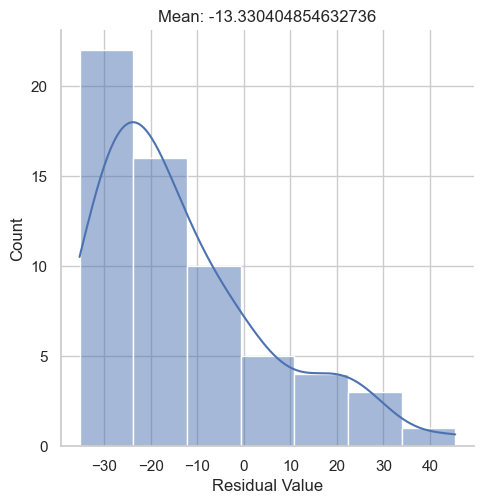

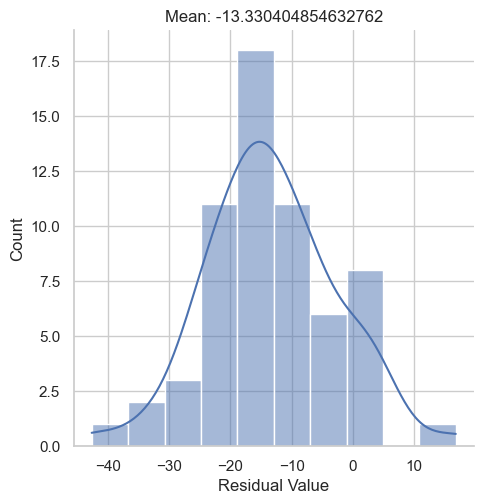

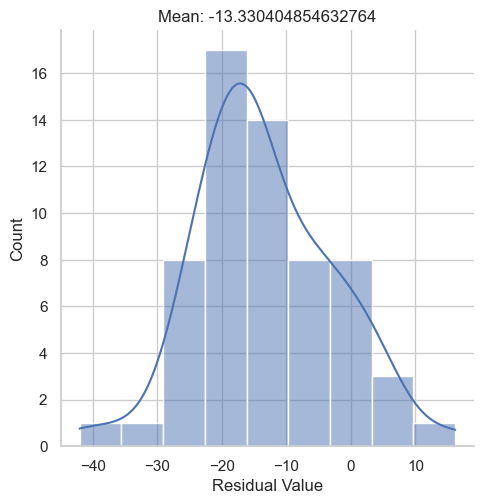

In [22]:
# Calculating residuals
resid_lasso = y_test - lasso_pred
resid_lmean = sum(resid_lasso)/len(resid_lasso)
resid_ridge = y_test - ridge_pred
resid_rmean = sum(resid_ridge)/len(resid_ridge)
resid_elastic = y_test - elastic_net_pred
resid_emean = sum(resid_elastic)/len(resid_elastic)

sns.set_theme(style='whitegrid')
sns.displot(resid_lasso, kde=True).set(title="Mean: " + str(resid_lmean), xlabel="Residual Value")
sns.displot(resid_ridge, kde=True).set(title="Mean: " + str(resid_rmean), xlabel="Residual Value")
sns.displot(resid_elastic, kde=True).set(title="Mean: " + str(resid_emean), xlabel="Residual Value")
plt.show()

In [25]:
ridge_perm = PermutationImportance(ridge, random_state=1).fit(X_test_pro, y_test)

eli5.show_weights(ridge_perm, feature_names = X_pro_colnames)

Weight,Feature
0.6686 ± 0.1095,Sugars
0.2044 ± 0.0569,Total Fat
0.0699 ± 0.0058,Cholesterol
0.0453 ± 0.0065,Protein
0.0133 ± 0.0135,Beverage_category_Smoothies
0.0082 ± 0.0038,Beverage_category_Frappuccino® Blended Coffee
0.0047 ± 0.0016,Trans Fat
0.0047 ± 0.0019,Dietary Fibre
0.0014 ± 0.0006,Beverage_category_Frappuccino® Light Blended Coffee
0.0012 ± 0.0009,Beverage_category_Shaken Iced Beverages


In [26]:
threshold_values = [0.0001, 0.0008, 0.0015, 0.002, 0.005, 0.015, 0.05]
maes = []
for value in threshold_values:
    select = SelectFromModel(ridge_perm, threshold=value, prefit=True)
    X_train_select = pd.DataFrame(select.transform(X_train_pro))
    X_test_select = pd.DataFrame(select.transform(X_test_pro))

    # Adding back names to columns
    sel_cols = [X_train_pro.columns[i] for i in range(len(X_train_pro.columns)) if select.get_support()[i]]
    sel_name = {}
    for idx in range(len(sel_cols)):
        sel_name[idx] = sel_cols[idx]
    X_train_select = X_train_select.rename(columns=sel_name)
    X_test_select = X_test_select.rename(columns=sel_name)
    X_train_select.head()

    print("Threshold: ", value)
    ridge = RidgeCV(alphas=(0.1,1.0,10.0),cv=None, scoring='neg_root_mean_squared_error')
    ridge.fit(X_train_select, y_train)
    ridge_pred = ridge.predict(X_test_select)
    eval_model(y_test, ridge_pred)
    maes.append(mean_absolute_error(y_test, ridge_pred))
    print("\n")
print(maes)

Threshold:  0.0001
RMSE:  17.16223697285132
MAE:  14.707289464471257
Max Error:  42.89423084363932
Percentage Error: 0.07586


Threshold:  0.0008
RMSE:  16.78224685647674
MAE:  14.288000755660944
Max Error:  44.1610500357192
Percentage Error: 0.0737


Threshold:  0.0015
RMSE:  16.719232770775317
MAE:  14.404990298644709
Max Error:  42.10008876538319
Percentage Error: 0.0743


Threshold:  0.002
RMSE:  16.719232770775317
MAE:  14.404990298644709
Max Error:  42.10008876538319
Percentage Error: 0.0743


Threshold:  0.005
RMSE:  16.90805635778516
MAE:  14.781276193370484
Max Error:  39.843843431572054
Percentage Error: 0.07624


Threshold:  0.015
RMSE:  17.16550076711155
MAE:  14.651127420075948
Max Error:  42.96105235646229
Percentage Error: 0.07557


Threshold:  0.05
RMSE:  22.60121331811508
MAE:  19.355296501358776
Max Error:  54.23551576028774
Percentage Error: 0.09984


[14.707289464471257, 14.288000755660944, 14.404990298644709, 14.404990298644709, 14.781276193370484, 14.6511274200759

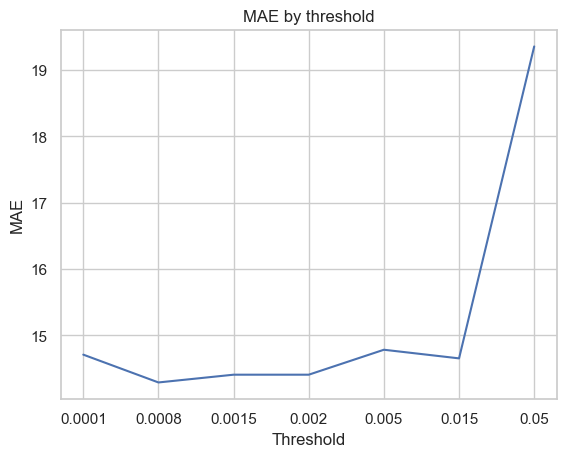

In [27]:
plot = sns.lineplot(y=maes, x=range(len(maes)))
plot.set(xlabel='Threshold', ylabel='MAE', title='MAE by threshold')
threshold_values.insert(0, 0.0001)
plot.set_xticklabels(threshold_values)
plt.show()